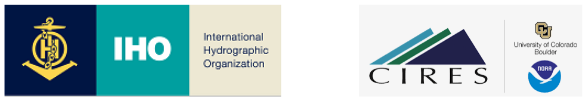


## Crowdsourced Bathymetry Data (CSB) Visualization

CSB is a citizen science project supported by the IHO and NOAA. This notebook will send an extract request to a data lake of crowdsourced bathymetry data stored as csv files on s3 and available through an AWS Athena service stored in parquet format. After generating a subset of the data within our geographic bounding box we can visualize the results as a 3D plot. The data lake hosted by the NOAA Big Data Project contains nearly 100,000,000 unique depth soundings from over 135 participating ships!

Read more here: https://noaa-bathymetry-pds.s3.amazonaws.com/readme.html

Or browse the bucket here: https://noaa-bathymetry-pds.s3.amazonaws.com/index.html

This notebook is available here:
https://github.com/dneufeldcu/notebooks/blob/main/esipCSBfinal.ipynb

Next time do this...
conda activate base
conda config --add channels conda-forge --force
conda install mamba
mamba update --yes --all
mamba create -n holoviz datashader geoviews hvplot

### Step 1. 
Let's install numby and matplot, hvplot and ipyleaflet to support the visualizations, and smart-open in order to read the csv file from s3.

In [6]:
import time
import csv
import requests
import numpy as np
import matplotlib.pyplot as plt
from smart_open import open as sm_open
from ipyleaflet import Map, WMSLayer, basemaps
import pandas as pd
import hvplot.pandas
import cartopy
import geoviews


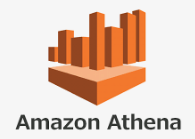
### Step 2.
Write a generic HTTP request. We'll populate the url with our Athena service endpoint and our JSON payload will contain our extract parameters.


In [7]:
def extract_request(url, payload):
    # Use a breakpoint in the code line below to debug your script.
    print(f'Request url: {url}')  # Press ⌘F8 to toggle the breakpoint.
    print(f'Payload: {payload}')
    r = requests.post(url, json=payload)
    print(r.status_code)
    return r.json()


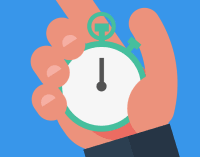
### Step 3.
Because our extract service is ansychronous we'll need poll the job status endpoint for status

In [8]:
def job_status(response):
    time.sleep(3)
    # Use a breakpoint in the code line below to debug your script.
    response_url = response['url']
    print(f'Response url: {response_url}')  # Press ⌘F8 to toggle the breakpoint.

    r = requests.get(response_url)
    return r

### Step 4.
Our main execution flow let's submit an extract request for depth soundings near the San Diego airport based on the extent of our map.


In [9]:
center = (32.715,-117.209)

map = Map(basemap=basemaps.Esri.NatGeoWorldMap, center=center, zoom=9)

wms = WMSLayer(
    url='https://gis.ngdc.noaa.gov/arcgis/services/csb/MapServer/WMSServer',
    layers='1',
    format='image/png',
    transparent=True,
)
map.add_layer(wms)
display(map)


Map(center=[32.715, -117.209], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zo…

In [10]:
# Grab the geographic extent from the map bounds

extent = f"{map.bounds[0][1]},{map.bounds[0][0]},{map.bounds[1][1]},{map.bounds[1][0]}"
print (extent)
payload = {}
payload['email'] = "david.neufeld@noaa.gov"
payload['bbox'] = extent
print(str(payload))

# Submit to the Athena service
response = extract_request('https://q20bz02j8b.execute-api.us-east-1.amazonaws.com/extract-request', payload)
status_response = job_status(response)
while status_response.status_code == 404:
    print("sleeping...")
    time.sleep(3)
    status_response = job_status(response)
    print(status_response.status_code)


job_payload = status_response.json()
print(job_payload['status'])
while str(job_payload['status']) == "RUNNING":
    print(f"Job is still {job_payload['status']}")
    print("sleep...")
    time.sleep(3)
    status_response = job_status(response)
    job_payload = status_response.json()
    print(status_response.status_code)

print(job_payload['url'])
s3_url = job_payload['url']

-118.55621337890626,32.252297287645575,-115.86181640625001,33.17664043594348
{'email': 'david.neufeld@noaa.gov', 'bbox': '-118.55621337890626,32.252297287645575,-115.86181640625001,33.17664043594348'}
Request url: https://q20bz02j8b.execute-api.us-east-1.amazonaws.com/extract-request
Payload: {'email': 'david.neufeld@noaa.gov', 'bbox': '-118.55621337890626,32.252297287645575,-115.86181640625001,33.17664043594348'}
201
Response url: https://q20bz02j8b.execute-api.us-east-1.amazonaws.com/extract-request/de1c8ed7-c1a9-47ce-ab6d-8f969da147e3
RUNNING
Job is still RUNNING
sleep...
Response url: https://q20bz02j8b.execute-api.us-east-1.amazonaws.com/extract-request/de1c8ed7-c1a9-47ce-ab6d-8f969da147e3
200
https://csb-pilot-delivery.s3.amazonaws.com/de1c8ed7-c1a9-47ce-ab6d-8f969da147e3.csv


In [11]:
# Let's look at the data data
df = pd.read_csv(s3_url)
df.head()

,lon,lat,depth,time,platform,provider
0,-117.190850,32.725857,3.29,2020-05-03 16:12:15.000,Copper Star,Rose Point
1,-117.190834,32.725900,3.29,2020-05-03 16:12:21.000,Copper Star,Rose Point
2,-117.190740,32.725807,3.29,2020-05-03 16:14:22.000,Copper Star,Rose Point
3,-117.190830,32.725820,3.29,2020-05-03 16:15:24.000,Copper Star,Rose Point
4,-117.190840,32.725840,3.29,2020-05-03 16:17:25.000,Copper Star,Rose Point


In [12]:
# Let's use smart_open to read directly from our s3 object
# Read more about smart_open here - https://pypi.org/project/smart-open/
def get_csv_s3(url):
    sm_open_file = sm_open(url, 'r')
    return sm_open_file

In [13]:
# Lastly let's visualize our data
# Are there outliers
def visualize(s3_url):
    # Read CSV
    csv_data = []
    csv_file = get_csv_s3(s3_url)

    csv_reader = csv.reader(csv_file, delimiter=',')
    i = 0
    for csv_row in csv_reader:
        if i > 0:
            csv_data.append([csv_row[0], csv_row[1], csv_row[2]])
        i = i + 1

    # Get X, Y, Z
    csv_data = np.array(csv_data)
    csv_data = csv_data.astype( np.float )
    x, y, z = csv_data[:, 0], csv_data[:, 1], (csv_data[:, 2] * -1)

    # Plot X,Y,Z
    fig = plt.figure()
    ax = fig.add_subplot( 111, projection='3d' )
    ax.plot_trisurf(x, y, z, color='white', edgecolors='grey', alpha=0.5)
    ax.scatter(x, y, z, c = 'red')
    plt.show()

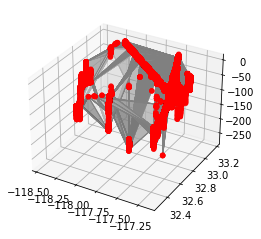

In [15]:
# Now visualize the file with mapplot
visualize(s3_url)

In [16]:
# Let's invert depth values so red is shallow and blue is deep
# Depth is in meters
def multiply_by_neg_one(arr):
    return np.multiply(arr,-1)

df['inverted_depth'] = df[['depth']].apply(multiply_by_neg_one)

In [17]:
# Now visualize with hvplot

df.hvplot.points(x='lon', y='lat', color='inverted_depth', rasterize=True, 
                 geo=True, cmap='jet', frame_width=600, tiles='OSM', hover=False)


:DynamicMap   []
   :Overlay
      .Tiles.I :Tiles   [x,y]
      .Image.I :Image   [lon,lat]   (lon_lat inverted_depth)

In [ ]:
print("Thank you, any questions?!")